In [24]:
%matplotlib inline

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='onedork')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

# reset default matplotlib rcParams
jtplot.reset()

**辅助函数**

In [99]:
def find_most_common(df, cat_col):
    '''查找DataFrame中指定列的最频繁值，一般用于填充缺失值'''
    tmp = df.groupby(cat_col)[cat_col].agg(len)
    tmp.sort_values(ascending=False, inplace=True)
    return tmp.index[0]

def find_miss_feat(df):
    '''传入一个DataFrame, 返回其中含有缺失值的列信息'''
    return df.dtypes[df.isnull().any(axis=0)==True]

def get_feats_name(df):
    '''传入一个DataFrame，返回数值和分类变量的列名，不包括ID和Target'''
    id_target = ['SK_ID_CURR', 'TARGET']
    cat_feat = [c for c in df.columns[df.dtypes == 'O'] if c not in id_target]
    num_feat = [c for c in df.columns[df.dtypes != 'O'] if c not in id_target]
    return cat_feat, num_feat

# 绘图函数
def plot_dist(df, feats, rotation=45):
    '''绘制feats中每个变量的数据分布
        如果变量是分类特征或者数值特征但其唯一值<=10: 先做value_counts，再绘制其对应的barplot，
        如果唯一值个数小于
        否则，直接绘制其dist分布
    '''
    # 随机设置图像颜色
    tmp = sns.color_palette('muted');shuffle(tmp);
    with sns.color_palette(tmp):
        _rows, _cols = len(feats) // 3 + 1 if len(feats) % 3 else len(feats) // 3, 3
        fig, ax = plt.subplots(_rows, _cols, figsize=(15, _rows * 4))
        for _id, c in enumerate(feats):
            if _rows > 1:
                _ax = ax[_id // _cols, _id % _cols]
            else:
                _ax = ax[_id % _cols]
            if df[c].dtype == 'O' or df[c].unique().shape[0] <= 10:
                tmp = df[c].value_counts()
                g = sns.barplot(x=tmp.index, y=tmp, ax=_ax)
                g.set_xticklabels(g.get_xticklabels(), rotation=45)
                _ax.set(title=c)
            else:
                sns.distplot(df[c], ax=_ax)
        plt.tight_layout()

def plot_cat(df, cat, feats):
    '''绘制不同cat值对应的feats的数据分布'''
    # 随机设置图像颜色
    tmp = sns.color_palette('muted');shuffle(tmp);
    
    _rows, _cols = len(feats) // 3 + 1 if len(feats) % 3 else len(feats) // 3, 3
    fig, ax = plt.subplots(_rows, _cols, figsize=(15, _rows * 4))
    with sns.color_palette(tmp):    
        for _id, c in enumerate(feats):
            if _rows > 1:
                _ax = ax[_id // _cols, _id % _cols]
            else:
                _ax = ax[_id % _cols]
            if df[c].dtype == 'O' or df[c].unique().shape[0] <= 10:
                # tmp = df.groupby([cat, c])[c].agg(len)
                _ = sns.countplot(x=c, data=df, hue=cat, ax=_ax)
            else:
                # 如果是数值型特征，就按照cat分类，依次绘制其分布图
                for v in df[cat].unique():
                    _ = sns.distplot(df.loc[df[cat]==v, c], ax=_ax)
        plt.tight_layout()

## 背景
不少人由于缺少信用记录而难以获得贷款，并且，这样的客户还占了大多数。

Home Credit 致力于扩大信用度量范围，为银行提供更加安全、良好的租借记录。为了确保这些未接受银行服务的人有更多良好的借用记录，Home Credit尝试利用更多的数据来源——包括通信和交易信息，来预测客户的还款能力。

尽管目前Home Credit已经在使用多种统计和机器学习方法来完成这样的预测，但他们还是向Kagglers寻求更完全地发掘数据潜力及价值的方法。这能确保那些有良好消费记录或者还款能力的人不被银行拒绝，并且提供一个更加成熟、合理的还款时间表，来确保客户能够得到良好的服务。

## 获取数据

In [4]:
from pathlib import Path

train = pd.read_csv(Path.cwd() / 'input' / 'application_train.csv')
test = pd.read_csv(Path.cwd() / 'input' / 'application_test.csv')

In [ ]:
bureau = pd.read_csv(Path.cwd() / 'input' / 'bureau.csv')
bureau_balance = pd.read_csv(Path.cwd() / 'input' / 'bureau_balance.csv')

In [ ]:
previous_app = pd.read_csv(Path.cwd() / 'input' / 'previous_application.csv')
repayments = pd.read_csv(Path.cwd() / 'input' / 'installments_payments.csv')
credit_card = pd.read_csv(Path.cwd() / 'input' / 'credit_card_balance.csv')
pos_cash = pd.read_csv(Path.cwd() / 'input' / 'POS_CASH_balance.csv')

### 构建测试集和训练集

In [5]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(train, test_size=0.1, random_state=42)
train_set.reset_index(inplace=True, drop=True)
test_set.reset_index(inplace=True, drop=True)

### 训练集基础信息

In [6]:
train_set.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,252724,0,Cash loans,F,N,Y,2,135000.0,1078200.0,31653.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,372834,0,Cash loans,M,N,Y,2,337500.0,1288350.0,37800.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
2,326336,1,Cash loans,F,Y,N,0,135000.0,521280.0,28408.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
3,382390,0,Cash loans,F,N,Y,0,144000.0,808650.0,31333.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
4,330511,0,Cash loans,F,N,Y,1,112500.0,942300.0,27679.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


In [5]:
print('Train set size: ', train_set.shape, '\nTest set size: ', test_set.shape)

Train set size:  (276759, 122) 
Test set size:  (30752, 122)


In [8]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276759 entries, 0 to 276758
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 257.6+ MB


In [9]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30752 entries, 0 to 30751
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 28.6+ MB


In [11]:
# 离散特征数据样本
train_set.select_dtypes(include=['object']).sample(5)
# train.select_dtypes(include=['int64']).iloc[:, :-20].sample(5).T
# train.select_dtypes(include=['flaot64']).sample(5).T

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
166193,Cash loans,F,N,N,Unaccompanied,Commercial associate,Higher education,Single / not married,House / apartment,Sales staff,WEDNESDAY,Industry: type 4,NaN,block of flats,"Stone, brick",No
36680,Revolving loans,M,Y,N,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Construction,reg oper account,block of flats,Wooden,No
10106,Cash loans,M,N,N,Unaccompanied,Commercial associate,Secondary / secondary special,Married,Municipal apartment,Laborers,SATURDAY,Business Entity Type 3,NaN,block of flats,Block,No
97485,Revolving loans,F,N,Y,Family,Working,Secondary / secondary special,Married,House / apartment,NaN,MONDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
50799,Cash loans,M,Y,Y,Other_A,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,TUESDAY,Mobile,NaN,NaN,NaN,NaN


## 数据分析 -- 主数据集

### 数据类型
详见：[字段描述](./字段描述.xlsx)

### 缺失值

In [12]:
# 离散特征
cat_na_feats = train_set.select_dtypes(include=['object']).columns[
    train_set.select_dtypes(include=['object']).isnull().any(axis=0)
    ]
len(cat_na_feats)

6

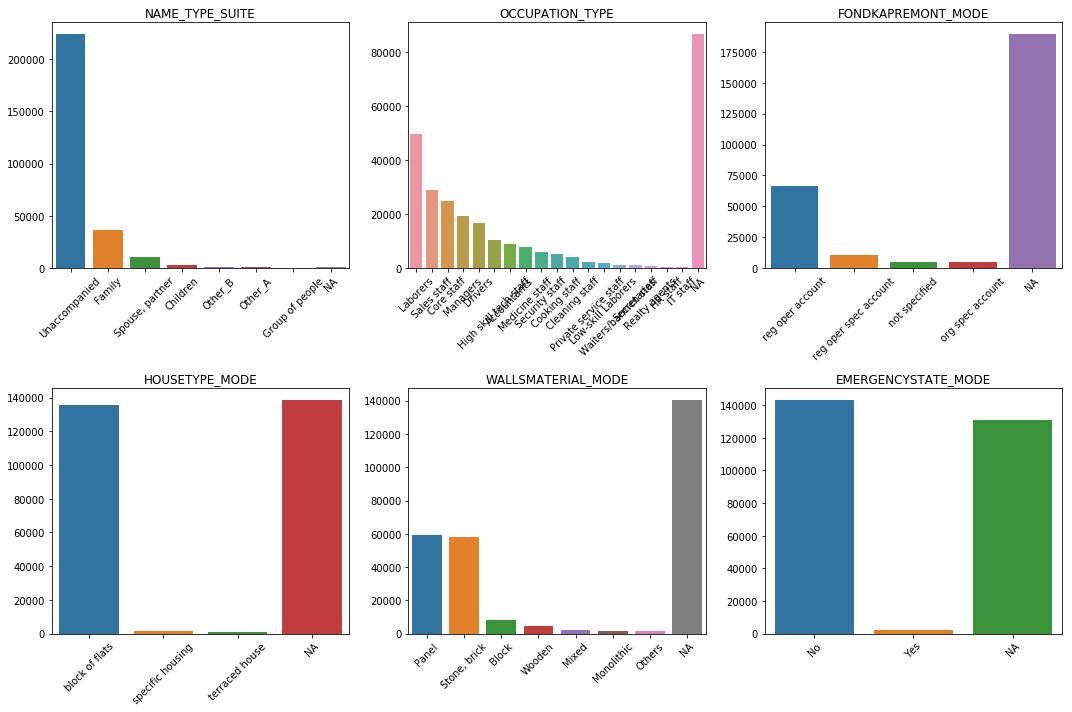

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for idx, feat in enumerate(cat_na_feats):
    _ax = ax[idx // 3, idx % 3]
    tmp = train_set[feat].value_counts()
    tmp = tmp.append(pd.Series([len(train_set)-tmp.sum()], index=['NA']))
    g = sns.barplot(x=tmp.index, y=tmp, ax=_ax)
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    _ax.set(title=feat)
plt.tight_layout()

In [16]:
# 整型特征
int_na_feats = train_set.select_dtypes(include=['int64']).columns[
    train_set.select_dtypes(include=['int64']).isnull().any(axis=0)
    ]
len(int_na_feats)

0

In [17]:
# 浮点数特征
float_na_feats = train_set.select_dtypes(include=['float64']).columns[
    train_set.select_dtypes(include=['float64']).isnull().any(axis=0)
    ]
len(float_na_feats)

61

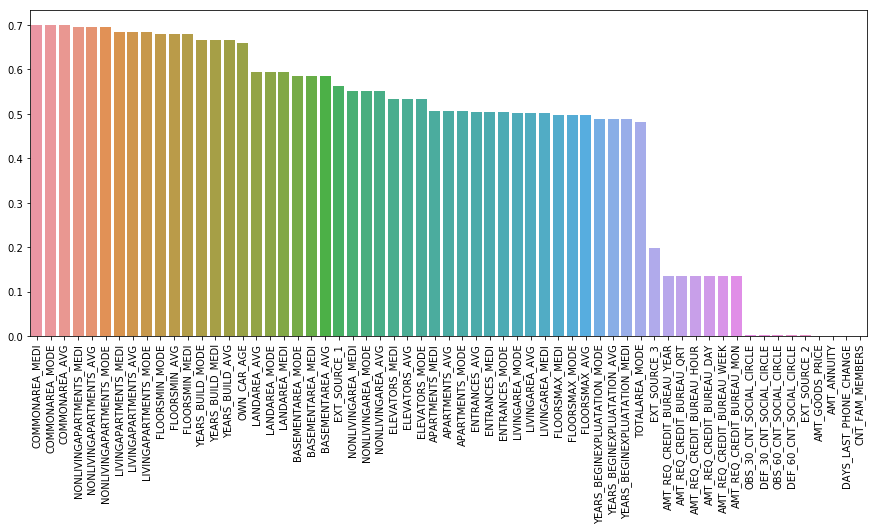

In [21]:
miss_rate = (train_set[float_na_feats].isnull().sum() / len(train_set)).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(15, 6))
g = sns.barplot(x=miss_rate.index, y=miss_rate, ax=ax)
_ = g.set_xticklabels(g.get_xticklabels(), rotation=90)

### 目标值

Text(1,23306,'22306')

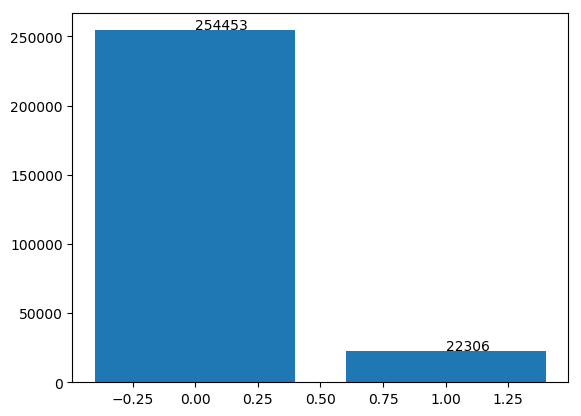

In [24]:
_target = train_set['TARGET'].value_counts()
plt.bar(_target.index, _target)
plt.text(0, _target[0]+1000, _target[0])
plt.text(1, _target[1]+1000, _target[1])

In [25]:
print(_target)
print('目标值数量：0: %d, 1: %d' % (_target[0], _target[1]))
print('正例占比: {:04.2f}%'.format(100 * _target[1] / _target.sum()))

0    254453
1     22306
Name: TARGET, dtype: int64
目标值数量：0: 254453, 1: 22306
正例占比: 8.06%


**结论**：这是一个不平衡数据集

### 特征分析

In [70]:
from scipy.stats import skew

除了target和id，特征可分为以下几组

* 申请人基础信息 x14
* 申请人的借贷信息 x3
* 申请人和当前申请相关的数据 x20
* 申请人的居住环境信息 x50
    * Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
* 过去30天或60天的社会关系 x4
* 客户是否提供了文件X x20
* 申请前在Credit Bureau的查询次数 x6
* 其他数据源 x3

**total = 120**


In [6]:
# ID和target
base = ['SK_ID_CURR', 'TARGET']
# 用户信息
info_cols = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
    'CNT_FAM_MEMBERS', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'OWN_CAR_AGE', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE'
    ]
# 当前申请的基础信息
loan_cols = ['NAME_CONTRACT_TYPE', 'AMT_CREDIT', 'AMT_ANNUITY']
# 当前申请相关信息
app_cols = [
    'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
    'NAME_TYPE_SUITE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
    'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'WEEKDAY_APPR_PROCESS_START',
    'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
    'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
    'LIVE_CITY_NOT_WORK_CITY', 'DAYS_LAST_PHONE_CHANGE'
    ]
# 申请人居住环境信息
live_cols = [
    'REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
    'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
    'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
    'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
    'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
    'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',
    'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
    'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
    'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
    'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
    'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE',
    'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'
    ]
# Social Surroundings
social_cols = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']
# 是否提交了文件X
doc_cols = [
    'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'
    ]
# Credit Bureau查询数据
bureau_cols = [
    'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'
    ]
# 其他数据源
ext_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

#### 1. 申请人基础信息

In [121]:
base_data = train_set[base + info_cols].copy()
base_data.dtypes.to_frame().T

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,CNT_FAM_MEMBERS,AMT_INCOME_TOTAL,DAYS_BIRTH,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OWN_CAR_AGE,ORGANIZATION_TYPE,OCCUPATION_TYPE
0,int64,int64,object,object,object,int64,float64,float64,int64,object,object,object,object,float64,object,object


In [122]:
base_data.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,CNT_FAM_MEMBERS,AMT_INCOME_TOTAL,DAYS_BIRTH,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OWN_CAR_AGE,ORGANIZATION_TYPE,OCCUPATION_TYPE
0,252724,0,F,N,Y,2,3.0,135000.0,-11141,Working,Higher education,Single / not married,House / apartment,NaN,Kindergarten,Core staff
1,372834,0,M,N,Y,2,3.0,337500.0,-14564,Commercial associate,Secondary / secondary special,Separated,House / apartment,NaN,Transport: type 4,Managers
2,326336,1,F,Y,N,0,2.0,135000.0,-15313,Working,Secondary / secondary special,Married,House / apartment,5.0,Other,Sales staff
3,382390,0,F,N,Y,0,2.0,144000.0,-9713,Commercial associate,Higher education,Married,House / apartment,NaN,Business Entity Type 3,Accountants
4,330511,0,F,N,Y,1,2.0,112500.0,-11469,Working,Higher education,Separated,House / apartment,NaN,Transport: type 4,Laborers


In [9]:
base_cat_feat, base_num_feat = get_feats_name(base_data)

**0) 数据预处理**

> 缺失值

* OCCUPATION_TYPE: 由于NA占比较高，单独设置为一个值
* CNT_FAM_MEMBERS: 只有一个缺失值，填充为1
* OWN_CAR_AGE: 
    * 由于没车的用户该列都是NA，考虑编码为100(或者一个负数?)，可以之后再调整；
    * 有车的用户有4个缺失值，用均值填充

> 转换

* DAYS_BIRTH: 把天数换成年龄（天），取个反

In [10]:
# 有缺失值的列
find_miss_feat(base_data)

CNT_FAM_MEMBERS    float64
OWN_CAR_AGE        float64
OCCUPATION_TYPE     object
dtype: object

In [11]:
# 处理OWN_CAR_AGE
base_data['OCCUPATION_TYPE'] = base_data['OCCUPATION_TYPE'].fillna('NA')
# 处理CNT_FAM_MEMBERS
base_data.loc[base_data['CNT_FAM_MEMBERS'].isnull(), 'CNT_FAM_MEMBERS'] = 1
# 处理
base_data.loc[
    (base_data['FLAG_OWN_CAR']=='Y') & (base_data['OWN_CAR_AGE'].isnull()),
    'OWN_CAR_AGE'
    ] = int(base_data.loc[(base_data['FLAG_OWN_CAR']=='Y'), 'OWN_CAR_AGE'].mean())
base_data.loc[(base_data['FLAG_OWN_CAR']=='N'), 'OWN_CAR_AGE'] = 100

# 年龄（天）
base_data['DAYS_BIRTH'] = -1 * base_data['DAYS_BIRTH']

**1) 数据分布**

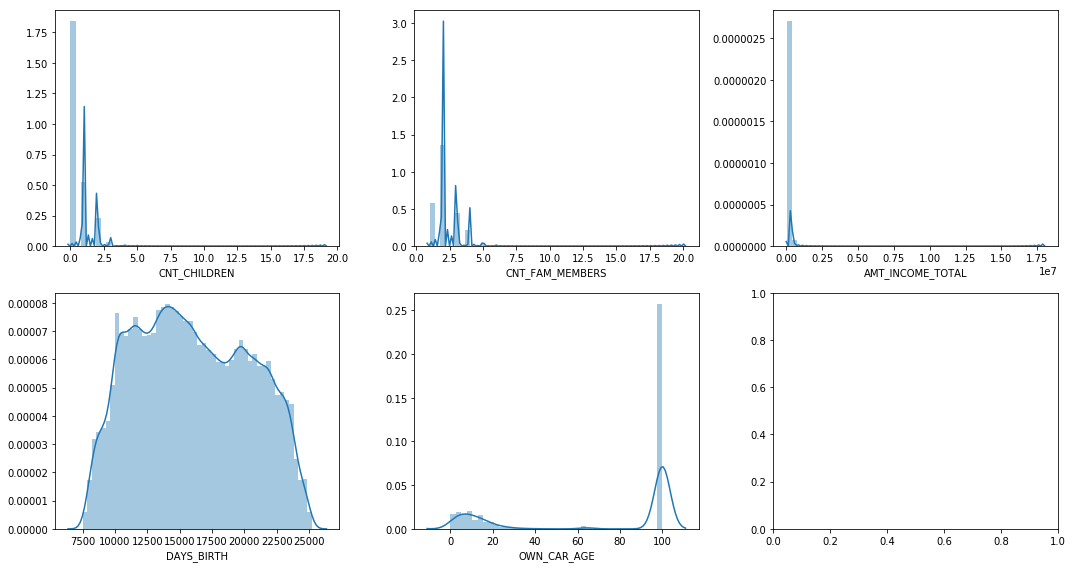

In [14]:
plot_dist(base_data, base_num_feat)

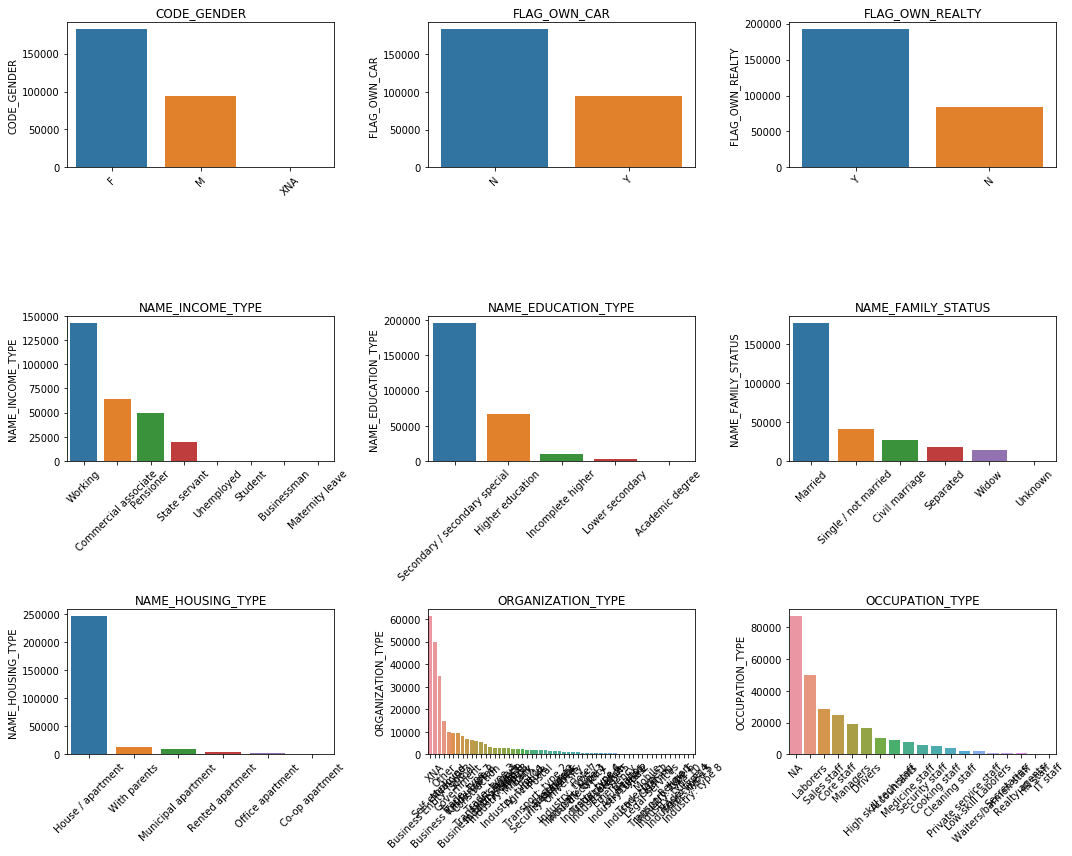

In [15]:
plot_dist(base_data, base_cat_feat)

**2) 对分类数据进行编码**

In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
encoder = {}
for col in base_data.dtypes[base_data.dtypes == 'O'].index:
    print("Processing column: ", col)
    encoder[col] = LabelEncoder().fit(base_data[col])
    base_data[col] = encoder[col].transform(base_data[col])

Processing column:  CODE_GENDER
Processing column:  FLAG_OWN_CAR
Processing column:  FLAG_OWN_REALTY
Processing column:  NAME_INCOME_TYPE
Processing column:  NAME_EDUCATION_TYPE
Processing column:  NAME_FAMILY_STATUS
Processing column:  NAME_HOUSING_TYPE
Processing column:  ORGANIZATION_TYPE
Processing column:  OCCUPATION_TYPE


**3) 特征间关系**

In [18]:
base_corr = base_data.drop('SK_ID_CURR', axis=1).corr()

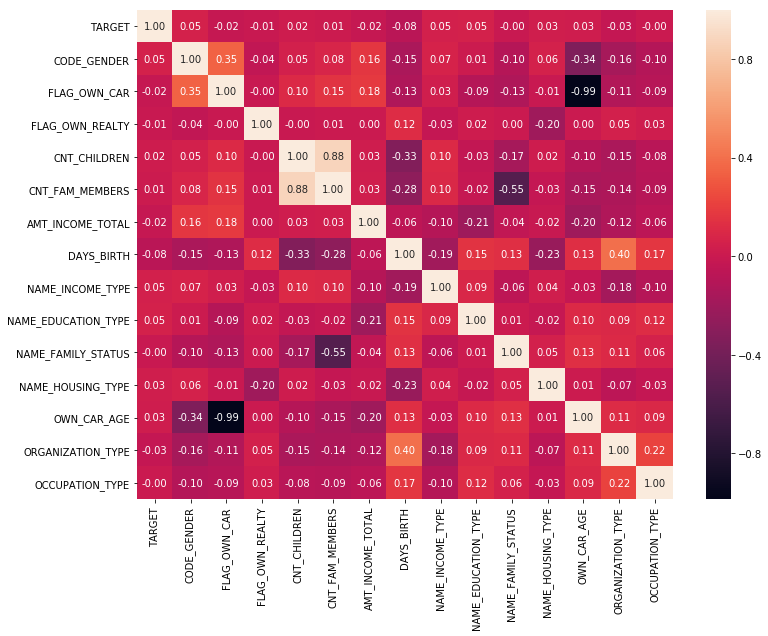

In [21]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(base_corr, annot=True, fmt='0.2f')

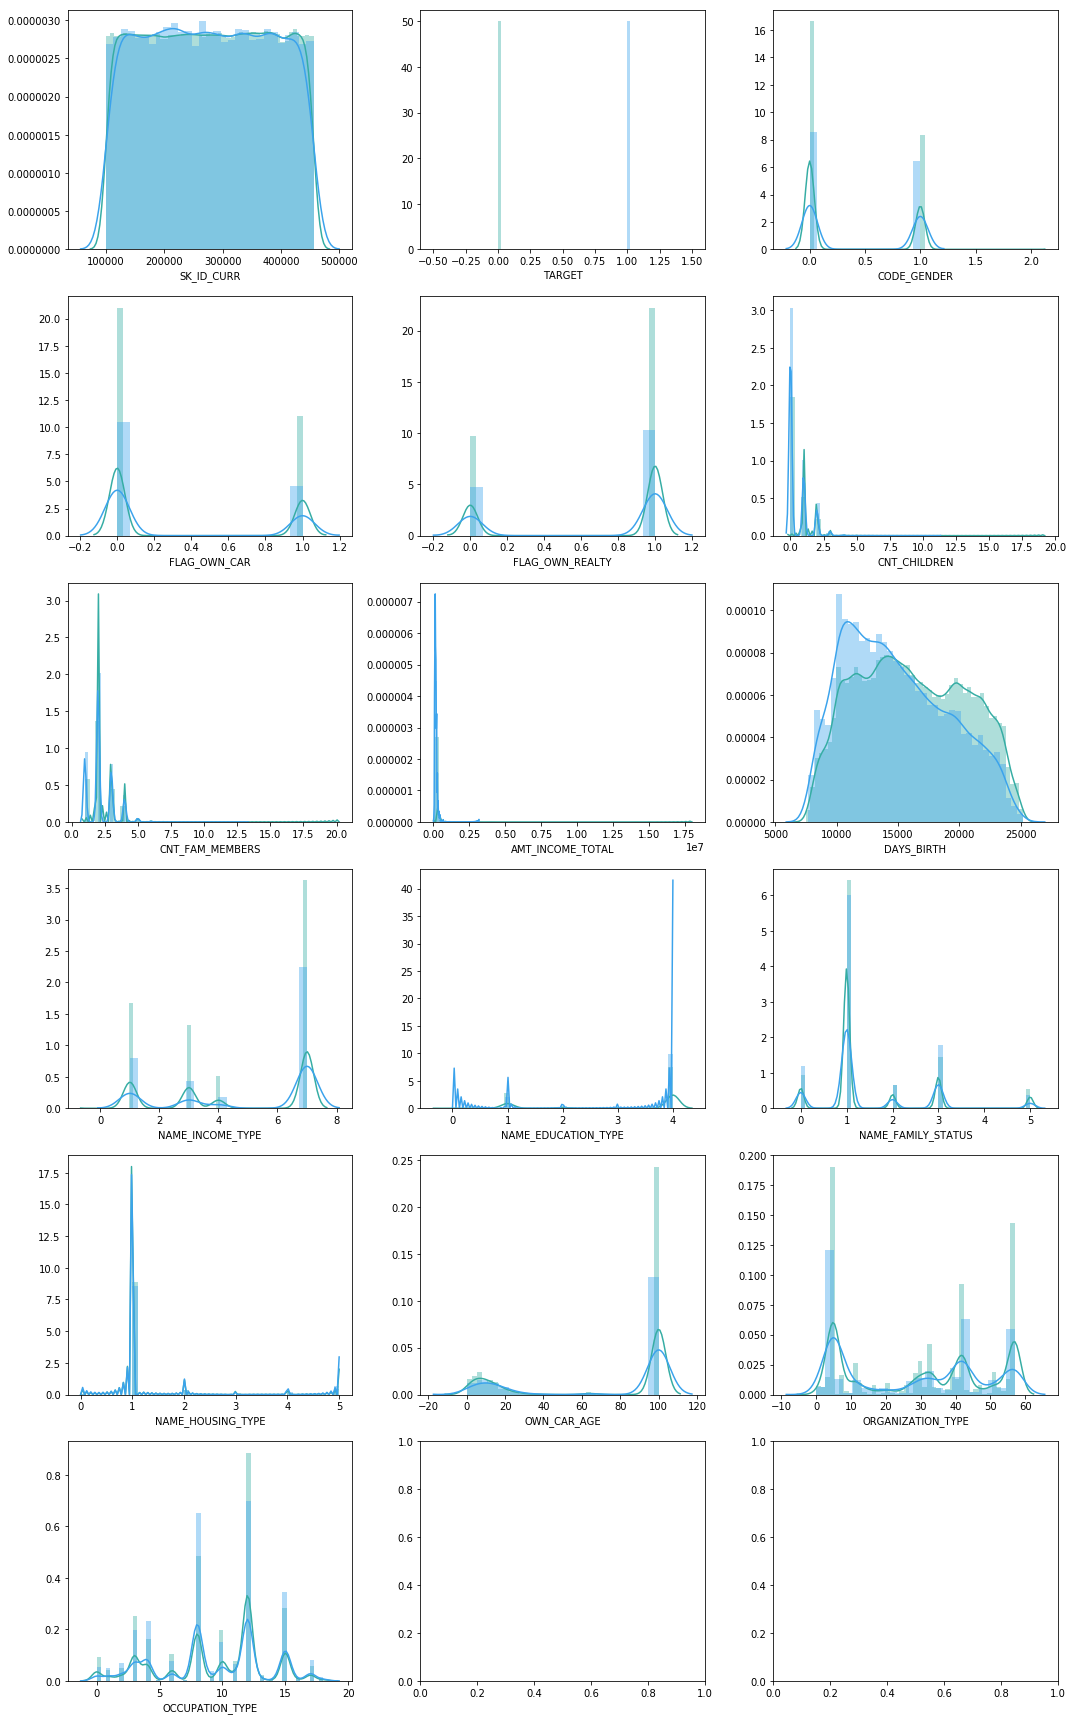

In [68]:
plot_cat(base_data, 'TARGET', base_data.columns)

In [71]:
skew(base_data['AMT_INCOME_TOTAL'])

28.640738658253337

In [78]:
tmp = loan_data['AMT_CREDIT'].max() - loan_data['AMT_CREDIT']
skew(tmp)

-1.2283166424945249

#### 2. 借贷信息

In [22]:
loan_data = train_set[['TARGET',] + loan_cols].copy()
loan_data.head()

,TARGET,NAME_CONTRACT_TYPE,AMT_CREDIT,AMT_ANNUITY
0,0,Cash loans,1078200.0,31653.0
1,0,Cash loans,1288350.0,37800.0
2,1,Cash loans,521280.0,28408.5
3,0,Cash loans,808650.0,31333.5
4,0,Cash loans,942300.0,27679.5


**0) 数据预处理**

AMT_ANNUITY: 有10个缺失值，暂时用均值填充

In [23]:
find_miss_feat(loan_data)

AMT_ANNUITY    float64
dtype: object

In [24]:
tmp = loan_data['AMT_ANNUITY'].mean()
loan_data['AMT_ANNUITY'] = loan_data['AMT_ANNUITY'].fillna(tmp)

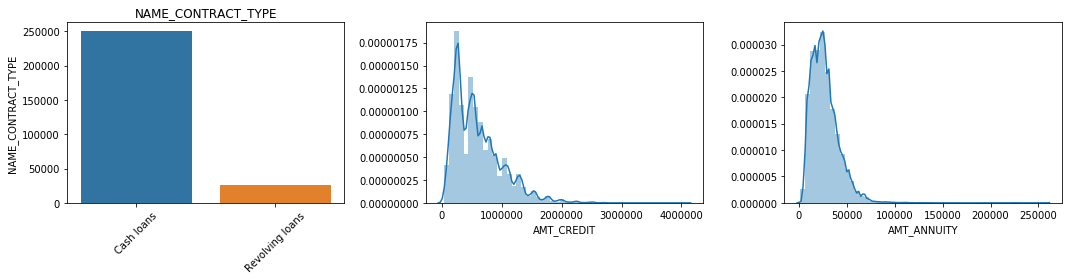

In [25]:
plot_dist(loan_data, loan_cols)

In [28]:
# 对Name_Contract_type编码
encoder = LabelEncoder()
loan_data['NAME_CONTRACT_TYPE'] = encoder.fit_transform(loan_data['NAME_CONTRACT_TYPE'])

In [31]:
# 将数值特征转换为log1p
for col in ['AMT_CREDIT', 'AMT_ANNUITY']:
    loan_data['Log_'+col] = np.log1p(loan_data[col])

In [32]:
# 计算变量间线性关系
loan_data.corr()

,TARGET,NAME_CONTRACT_TYPE,AMT_CREDIT,AMT_ANNUITY,Log_AMT_CREDIT,Log_AMT_ANNUITY
TARGET,1.000000,-0.031240,-0.030981,-0.012894,-0.012733,0.000566
NAME_CONTRACT_TYPE,-0.031240,1.000000,-0.221210,-0.240843,-0.246869,-0.318904
AMT_CREDIT,-0.030981,-0.221210,1.000000,0.770185,0.919984,0.764109
AMT_ANNUITY,-0.012894,-0.240843,0.770185,1.000000,0.759940,0.930935
Log_AMT_CREDIT,-0.012733,-0.246869,0.919984,0.759940,1.000000,0.844869
Log_AMT_ANNUITY,0.000566,-0.318904,0.764109,0.930935,0.844869,1.000000


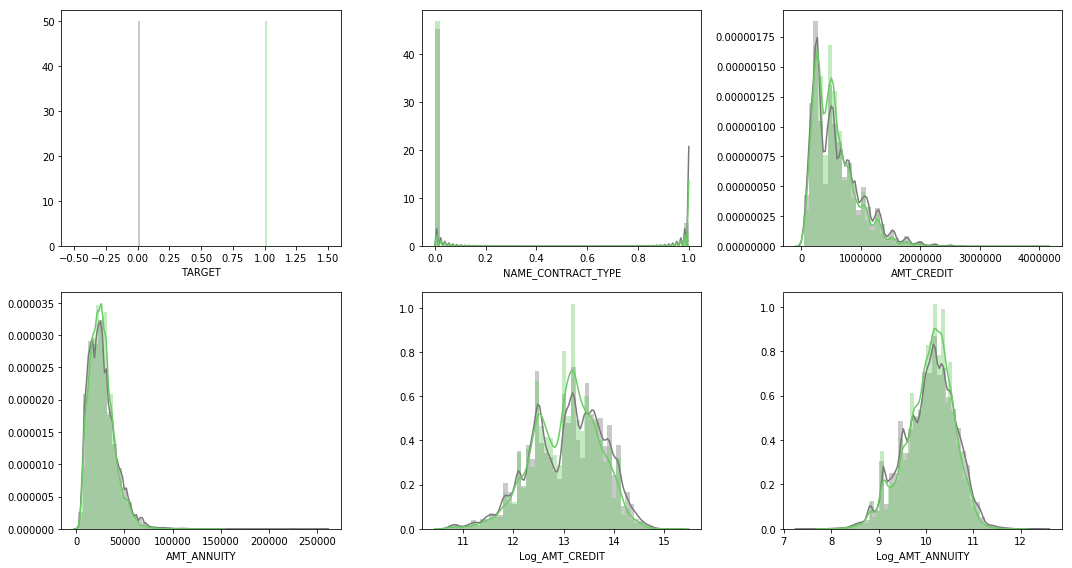

In [123]:
plot_cat(loan_data, 'TARGET', loan_data.columns)

#### 3. 申请信息

In [137]:
app_data = train_set[['TARGET',] + app_cols].copy()
app_data.head()

,TARGET,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,NAME_TYPE_SUITE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,FLAG_EMAIL,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,DAYS_LAST_PHONE_CHANGE
0,0,900000.0,-546,-2842.0,-3728,Family,1,1,0,1,...,0,FRIDAY,15,0,0,0,0,0,0,-1402.0
1,0,1125000.0,-1720,-8557.0,-4080,Unaccompanied,1,1,0,1,...,0,TUESDAY,11,0,0,0,0,0,0,-852.0
2,1,450000.0,-398,-1334.0,-1346,Unaccompanied,1,1,0,1,...,0,SATURDAY,16,0,0,0,0,1,1,-1327.0
3,0,675000.0,-3078,-2422.0,-1411,Unaccompanied,1,1,1,1,...,0,TUESDAY,8,0,0,0,0,0,0,-2256.0
4,0,675000.0,-104,-4946.0,-3165,Unaccompanied,1,1,0,1,...,0,SUNDAY,14,0,0,0,0,0,0,-874.0


**0) 数据预处理**

> 缺失值

* NAME_TYPE_SUITE: 用众数（`Unaccompanied`）填充
* DAYS_LAST_PHONE_CHANGE: 只有一个缺失值，填充为均值
* AMT_GOODS_PRICE: 填充为均值


In [138]:
# 有缺失值的列
find_miss_feat(app_data)

AMT_GOODS_PRICE           float64
NAME_TYPE_SUITE            object
DAYS_LAST_PHONE_CHANGE    float64
dtype: object

In [10]:
find_most_common(app_data, 'NAME_TYPE_SUITE')

'Unaccompanied'

In [11]:
app_data['NAME_TYPE_SUITE'].fillna(
    find_most_common(app_data, 'NAME_TYPE_SUITE'), inplace=True)
app_data['DAYS_LAST_PHONE_CHANGE'].fillna(
    int(app_data['DAYS_LAST_PHONE_CHANGE'].mean()), inplace=True)
app_data['AMT_GOODS_PRICE'].fillna(
    app_data['AMT_GOODS_PRICE'].mean(), inplace=True)

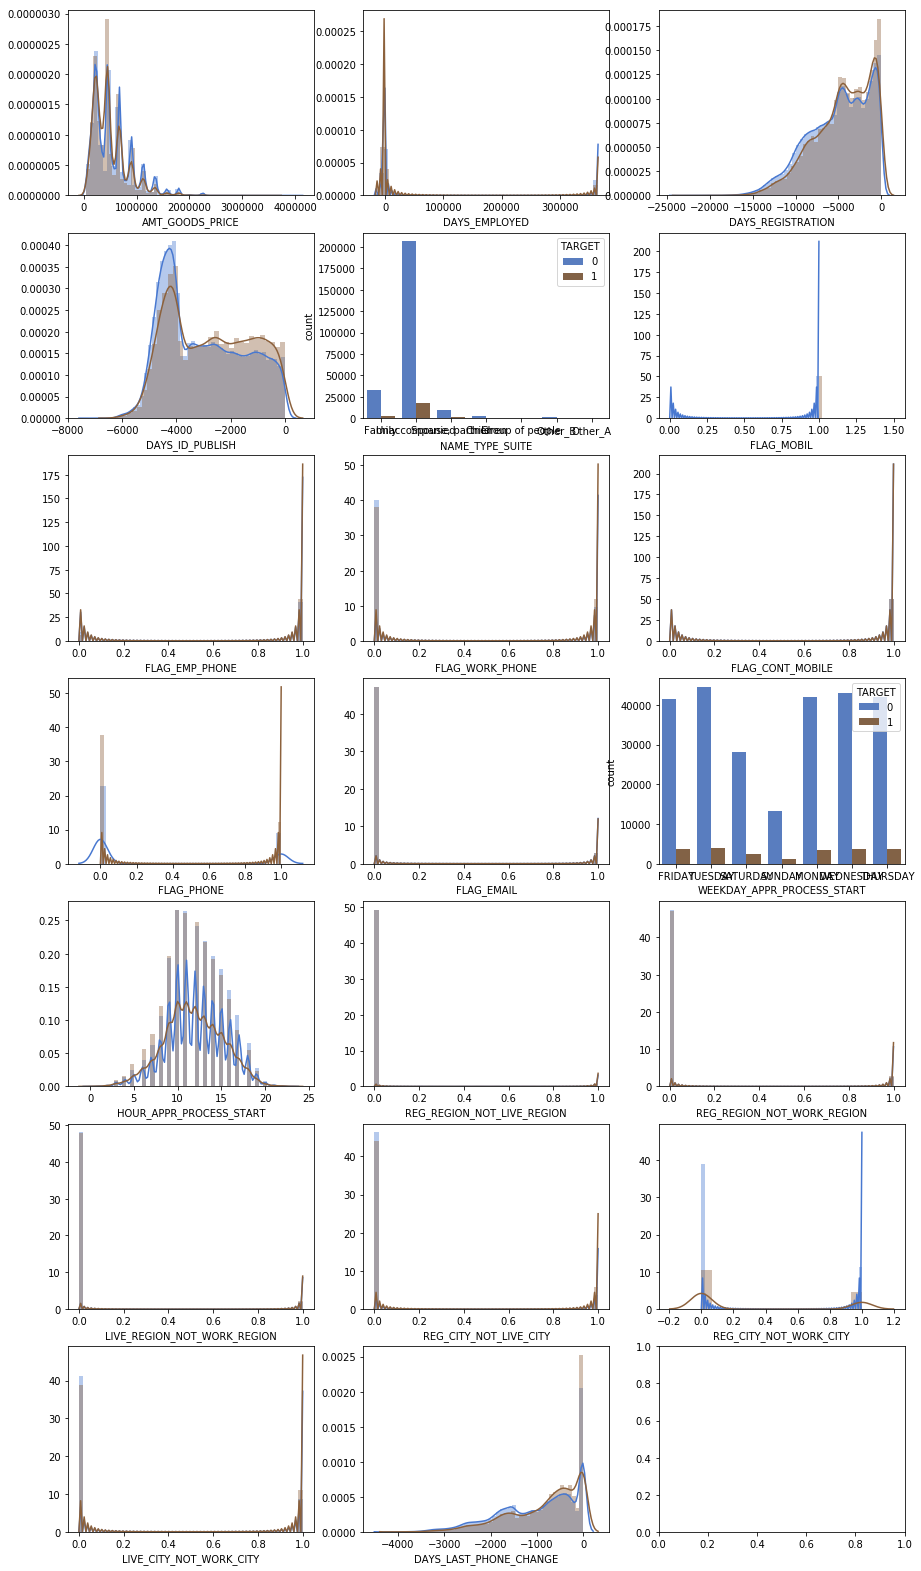

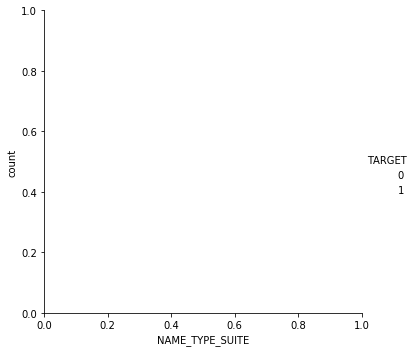

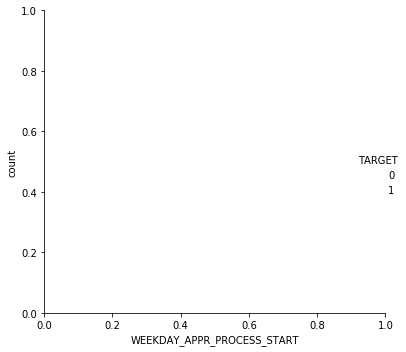

In [25]:
plot_cat(app_data, 'TARGET', app_data.drop('TARGET', axis=1).columns)

#### 4. 居住环境信息

In [26]:
live_data = train_set[['TARGET',] + live_cols].copy()
live_data.head()

,TARGET,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,0,0.010643,2,2,0.1278,NaN,0.9771,0.6872,0.0130,0.00,...,0.0379,0.0752,0.0245,0.1397,0.0333,reg oper account,block of flats,0.0260,"Stone, brick",No
1,0,0.022625,2,2,0.2247,0.0000,0.9806,0.7348,0.0507,0.24,...,0.1637,0.1847,0.2248,0.0078,0.1380,reg oper account,block of flats,0.2031,Panel,No
2,1,0.005144,2,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.018850,2,2,0.0912,0.1020,0.9955,0.9388,0.0316,0.16,...,0.0199,0.0727,0.1220,0.0136,0.0496,reg oper account,block of flats,0.1166,"Stone, brick",No
4,0,0.009657,2,2,0.0619,0.0636,0.9821,0.7552,0.0196,0.00,...,0.0113,0.0513,0.0536,0.0000,0.0000,reg oper spec account,block of flats,0.0414,Panel,No


**0) 数据预处理**

> 缺失值

* 大于阈值的数值特征删掉
* 小于阈值的数值特征用均值填充
* 离散特征填充为特定值

In [27]:
find_miss_feat(live_data)

APARTMENTS_AVG                  float64
BASEMENTAREA_AVG                float64
YEARS_BEGINEXPLUATATION_AVG     float64
YEARS_BUILD_AVG                 float64
COMMONAREA_AVG                  float64
ELEVATORS_AVG                   float64
ENTRANCES_AVG                   float64
FLOORSMAX_AVG                   float64
FLOORSMIN_AVG                   float64
LANDAREA_AVG                    float64
LIVINGAPARTMENTS_AVG            float64
LIVINGAREA_AVG                  float64
NONLIVINGAPARTMENTS_AVG         float64
NONLIVINGAREA_AVG               float64
APARTMENTS_MODE                 float64
BASEMENTAREA_MODE               float64
YEARS_BEGINEXPLUATATION_MODE    float64
YEARS_BUILD_MODE                float64
COMMONAREA_MODE                 float64
ELEVATORS_MODE                  float64
ENTRANCES_MODE                  float64
FLOORSMAX_MODE                  float64
FLOORSMIN_MODE                  float64
LANDAREA_MODE                   float64
LIVINGAPARTMENTS_MODE           float64


In [28]:
find_miss_feat(live_data).shape

(47,)

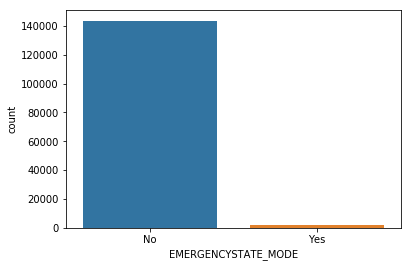

In [42]:
sns.countplot(live_data['EMERGENCYSTATE_MODE'].dropna())

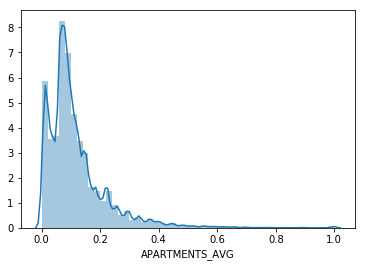

In [37]:
sns.distplot(live_data['APARTMENTS_AVG'].dropna())

#### 5. 社交信息

In [44]:
social_data = train_set[['TARGET',] + social_cols].copy()
social_data.head()

,TARGET,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
0,0,0.0,0.0,0.0,0.0
1,0,5.0,2.0,5.0,2.0
2,1,0.0,0.0,0.0,0.0
3,0,3.0,0.0,3.0,0.0
4,0,2.0,0.0,2.0,0.0


**0) 数据预处理**

> 缺失值

* 缺失值都填充为0

> 离群点

* 可以考虑设置阈值，将大于阈值的值置为`其他`或者阈值本身（例如：阈值为10，大于等于10的值置为10）

In [45]:
find_miss_feat(social_data)

OBS_30_CNT_SOCIAL_CIRCLE    float64
DEF_30_CNT_SOCIAL_CIRCLE    float64
OBS_60_CNT_SOCIAL_CIRCLE    float64
DEF_60_CNT_SOCIAL_CIRCLE    float64
dtype: object

In [53]:
for c in social_cols:
    social_data[c].fillna(0, inplace=True)

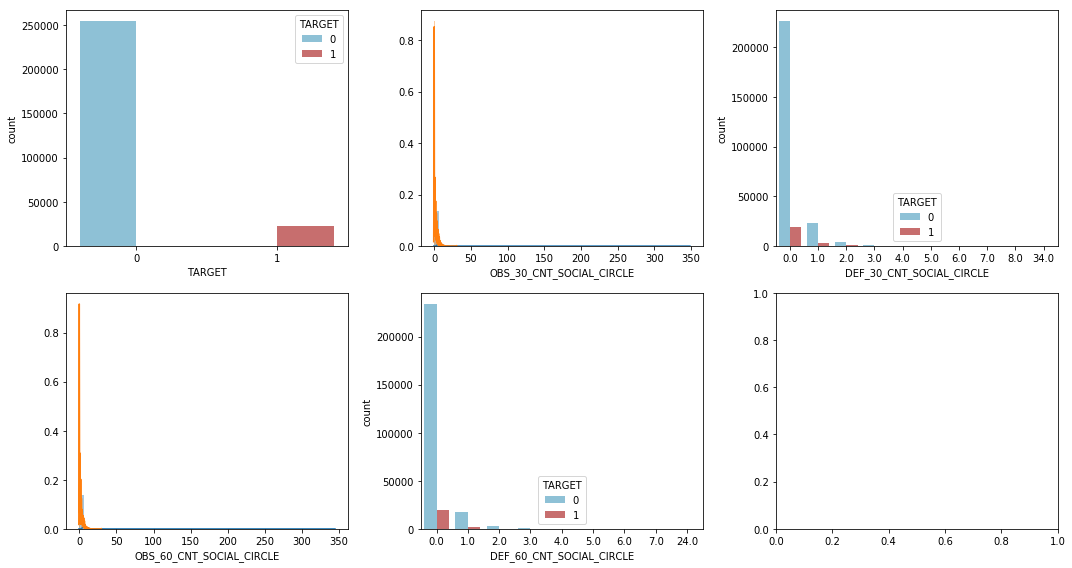

In [100]:
plot_cat(social_data, 'TARGET', social_data.columns)

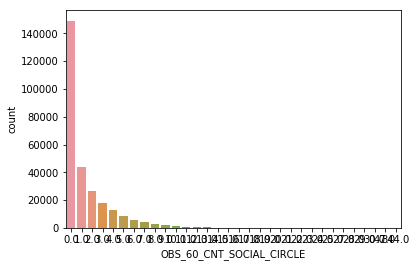

In [103]:
sns.countplot(social_data['OBS_60_CNT_SOCIAL_CIRCLE'])

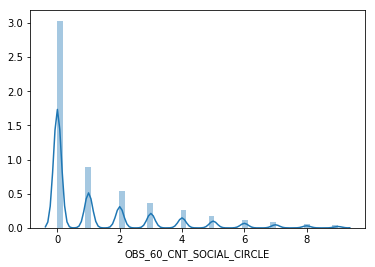

In [104]:
sns.distplot(social_data.loc[social_data['OBS_60_CNT_SOCIAL_CIRCLE'] < 10, 'OBS_60_CNT_SOCIAL_CIRCLE'])

In [108]:
social_data.loc[social_data['OBS_60_CNT_SOCIAL_CIRCLE'] < 11].shape[0] / social_data.shape[0]

0.9913354217929679

#### 6. 提交文件

In [66]:
doc_data = train_set[['TARGET',] + doc_cols].copy()
doc_data.head()

,TARGET,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
find_miss_feat(doc_data)

Series([], dtype: object)

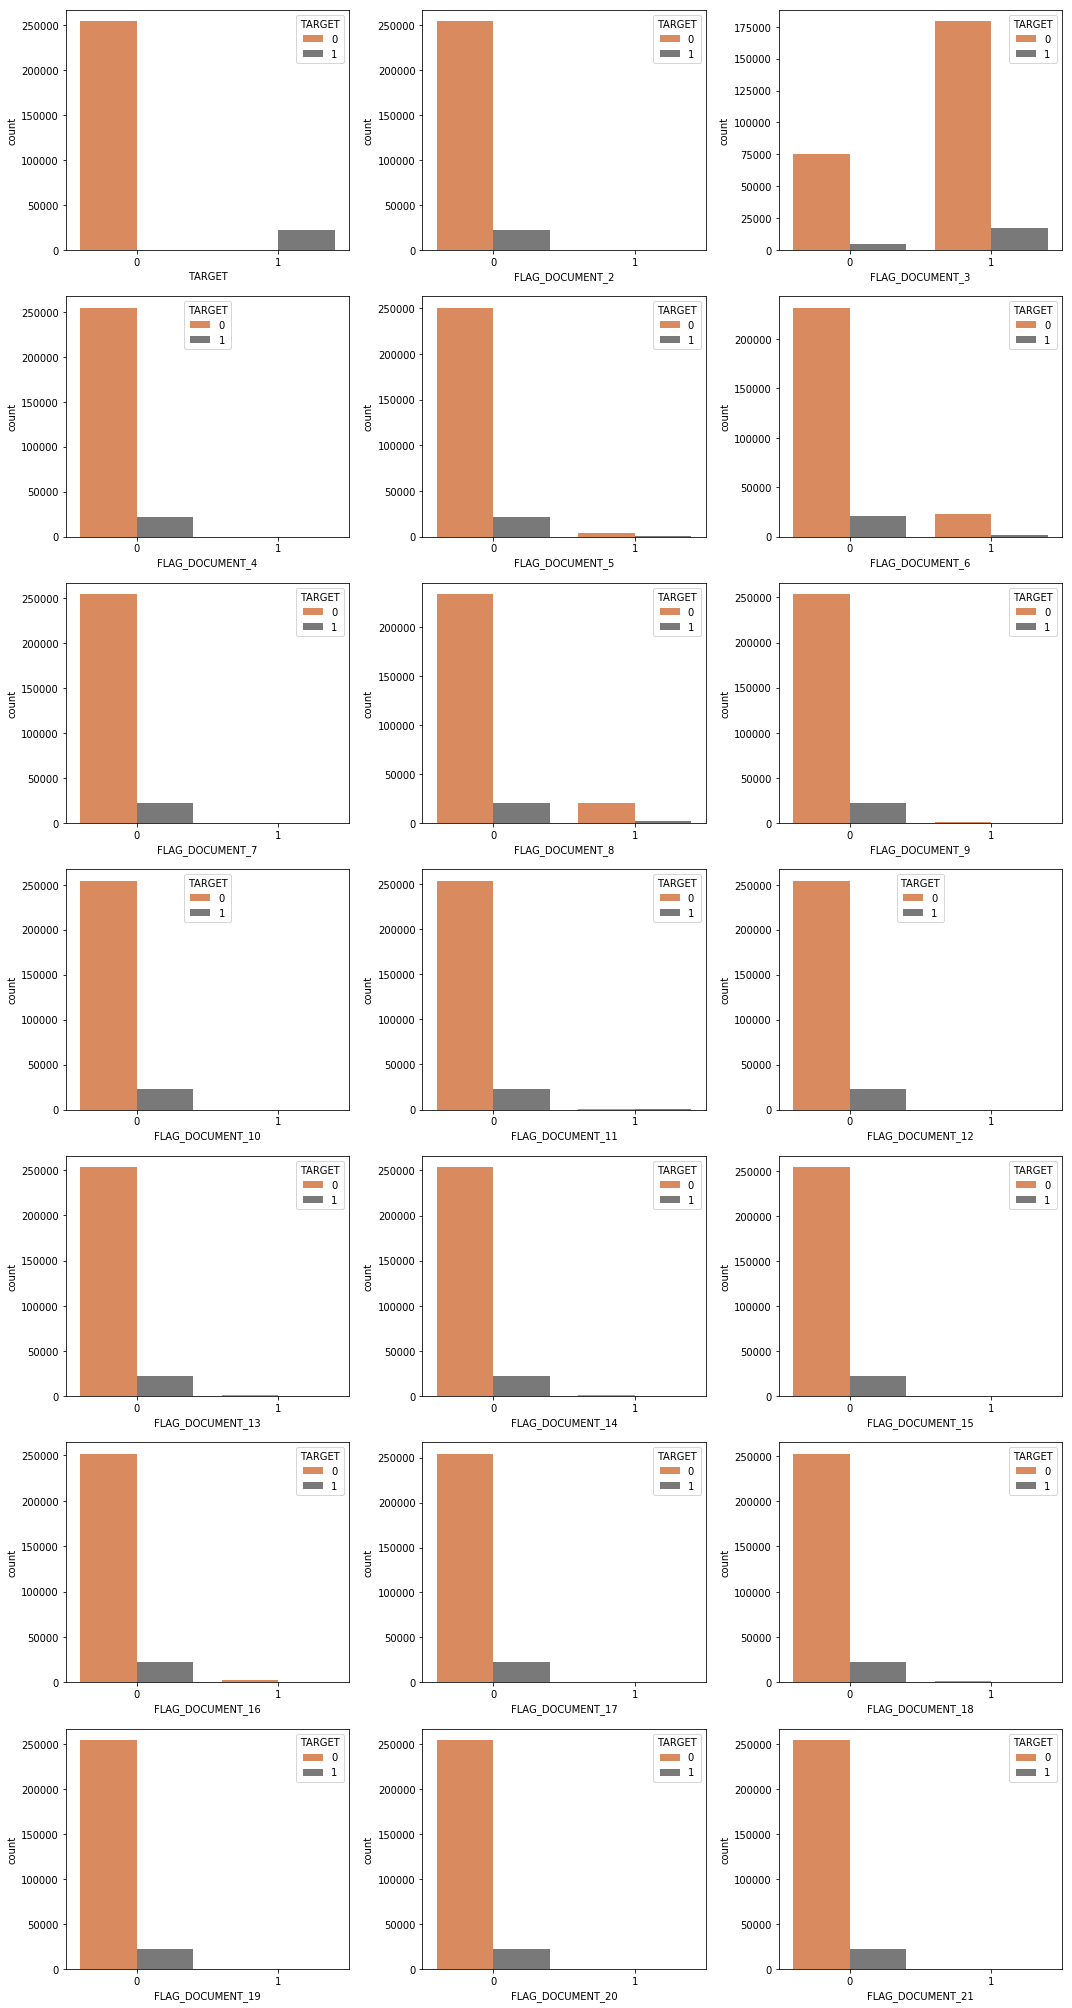

In [109]:
plot_cat(doc_data, 'TARGET', doc_data.columns)

In [72]:
doc_data.corr()['TARGET'].to_frame().T

,TARGET,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
TARGET,1.0,0.007622,0.04482,-0.002579,-0.000841,-0.028887,-0.001412,-0.007813,-0.004283,-0.001258,...,-0.000563,-0.011471,-0.009204,-0.005889,-0.012005,-0.002994,-0.008446,-0.001129,-0.001218,0.001952


#### 7. bureau数据

**0) 数据预处理**

> 缺失值

* method1. 缺失值都填充为0
* method2. 按比例填充


In [75]:
bureau_data = train_set[['TARGET',] + bureau_cols].copy()
bureau_data.head()

,TARGET,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0.0,0.0,0.0,0.0,0.0,2.0
2,1,0.0,0.0,0.0,0.0,1.0,2.0
3,0,0.0,0.0,0.0,0.0,0.0,2.0
4,0,0.0,0.0,0.0,0.0,0.0,3.0


In [76]:
find_miss_feat(bureau_data)

AMT_REQ_CREDIT_BUREAU_HOUR    float64
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
dtype: object

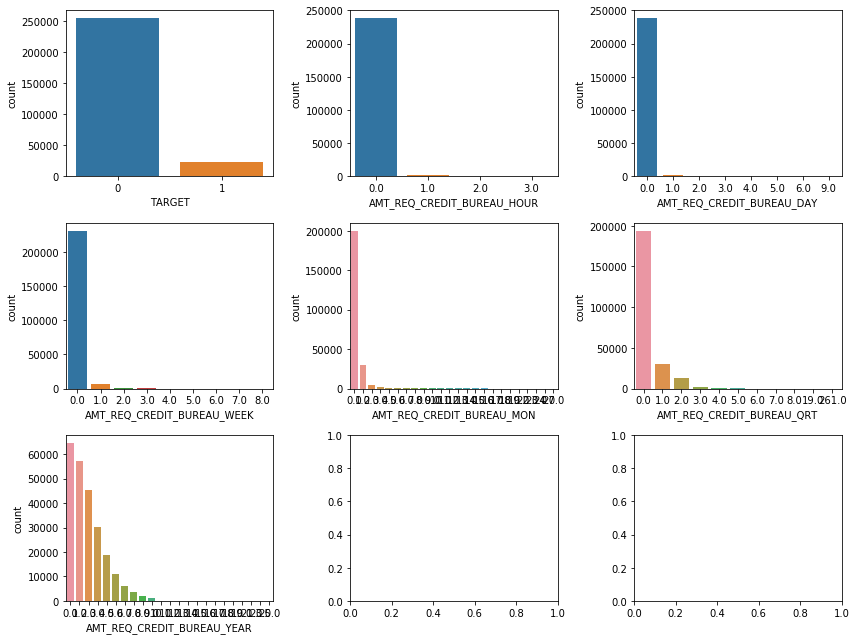

In [141]:
fig, ax = plt.subplots(3, 3, figsize=(12, 9))
for idx, c in enumerate(bureau_data.columns):
    _ax = ax[idx // 3, idx % 3]
    sns.countplot(bureau_data[c].dropna(), ax=_ax)
plt.tight_layout()

In [142]:
for c in bureau_data.columns:
    print(c, ':', bureau_data[c].unique())

TARGET : [0 1]
AMT_REQ_CREDIT_BUREAU_HOUR : [ 0. nan  1.  2.  3.]
AMT_REQ_CREDIT_BUREAU_DAY : [ 0. nan  1.  2.  6.  4.  3.  5.  9.]
AMT_REQ_CREDIT_BUREAU_WEEK : [ 0. nan  1.  2.  3.  4.  5.  6.  7.  8.]
AMT_REQ_CREDIT_BUREAU_MON : [ 0.  3. nan  1.  2. 13.  4.  5.  6. 10. 11.  8.  9. 16. 12.  7. 15. 14.
 22. 17. 19. 18. 27. 24. 23.]
AMT_REQ_CREDIT_BUREAU_QRT : [  0.   1.  nan   2.   3.   5.   6.   4.   7.   8. 261.  19.]
AMT_REQ_CREDIT_BUREAU_YEAR : [ 1.  2.  3.  6.  4. nan  0.  7.  5.  9.  8. 12. 13. 14. 23. 18. 11. 15.
 10. 17. 16. 19. 25. 21.]


In [146]:
bureau_data.isnull().any(axis=0)

TARGET                        False
AMT_REQ_CREDIT_BUREAU_HOUR     True
AMT_REQ_CREDIT_BUREAU_DAY      True
AMT_REQ_CREDIT_BUREAU_WEEK     True
AMT_REQ_CREDIT_BUREAU_MON      True
AMT_REQ_CREDIT_BUREAU_QRT      True
AMT_REQ_CREDIT_BUREAU_YEAR     True
dtype: bool

#### 8. 其他数据源

**0) 数据预处理**

> 缺失值

* method1. 缺失值都填充为均值
* method2. 填充为均值，然后加一个随机的bias

In [114]:
ext_data = train_set[['TARGET',] + ext_cols].copy()
ext_data.head()

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,0,0.234972,0.674088,0.617826
1,0,NaN,0.719454,0.492060
2,1,0.624646,0.505922,0.646330
3,0,0.741006,0.659509,0.132597
4,0,0.422269,0.558825,0.368969


In [115]:
find_miss_feat(ext_data)

EXT_SOURCE_1    float64
EXT_SOURCE_2    float64
EXT_SOURCE_3    float64
dtype: object

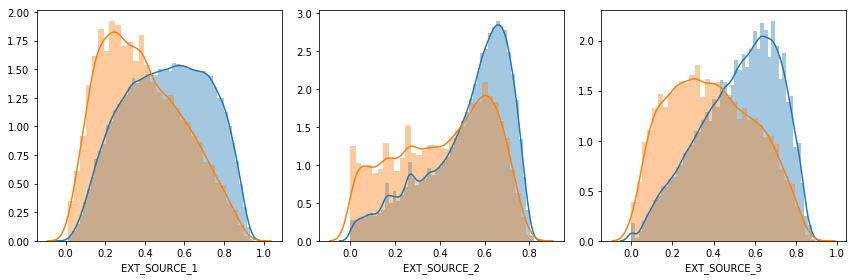

In [120]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for idx, c in enumerate(ext_data.drop('TARGET', axis=1).columns):
    _ax = ax[idx]
    sns.distplot(ext_data.loc[ext_data['TARGET']==0, c].dropna(), ax=_ax)
    sns.distplot(ext_data.loc[ext_data['TARGET']==1, c].dropna(), ax=_ax)
plt.tight_layout()

## Bureau数据集

In [6]:
bureau = pd.read_csv(Path.cwd() / 'input' / 'bureau.csv')

In [35]:
bureau.shape

(1716428, 17)

In [7]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


### Bureau_balance

In [31]:
bureau_balance.sample(10)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
10191064,5744463,-4,C
5420892,5925416,-32,C
22456339,6107293,-11,C
8326002,5947297,-32,C
9936553,5189456,-54,0
3541818,5212811,-38,0
25469330,5706920,-14,C
627377,5853718,-27,X
20665044,6189545,-20,C
2323566,5700244,-61,C


In [33]:
bureau_balance.shape

(27299925, 3)

In [32]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
SK_ID_BUREAU      int64
MONTHS_BALANCE    int64
STATUS            object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [ ]:
bureau_balance

### Previous application

In [37]:
previous_app.shape

(1670214, 37)

In [39]:
previous_app.sample(6)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1280311,2593867,441957,Revolving loans,7875.000,0.0,157500.0,NaN,NaN,MONDAY,15,...,Consumer electronics,0.0,XNA,Card X-Sell,-1404.0,-1370.0,365243.0,-1370.0,-332.0,0.0
668040,1401513,389479,Cash loans,NaN,0.0,0.0,NaN,NaN,SUNDAY,10,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1571955,1897109,122618,Cash loans,22134.645,229500.0,284107.5,NaN,229500.0,SUNDAY,11,...,XNA,18.0,middle,Cash X-Sell: middle,365243.0,-717.0,-207.0,-207.0,-201.0,1.0
1316465,2610586,384985,Cash loans,23971.500,450000.0,450000.0,NaN,450000.0,MONDAY,9,...,XNA,24.0,low_normal,Cash Street: low,365243.0,-1490.0,-800.0,-1130.0,-1125.0,0.0
1446247,1399803,170242,Consumer loans,12131.460,125955.0,113697.0,22500.0,125955.0,THURSDAY,13,...,Consumer electronics,12.0,middle,POS household with interest,NaN,NaN,NaN,NaN,NaN,NaN
768876,2338860,443337,Consumer loans,5062.455,48204.0,43380.0,4824.0,48204.0,WEDNESDAY,7,...,Connectivity,12.0,low_normal,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# 历史借贷样本
previous_app[previous_app['SK_ID_CURR']==441957].head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
509425,1760386,441957,Cash loans,15452.100,315000.0,315000.0,NaN,315000.0,SUNDAY,15,...,XNA,48.0,middle,Cash X-Sell: middle,365243.0,-208.0,1202.0,365243.0,365243.0,0.0
916262,1539568,441957,Consumer loans,5457.150,38610.0,39960.0,2250.0,38610.0,SATURDAY,8,...,Connectivity,12.0,high,POS mobile with interest,365243.0,-2148.0,-1818.0,-2028.0,-2024.0,0.0
1042005,2379412,441957,Cash loans,11414.745,157500.0,183487.5,NaN,157500.0,THURSDAY,12,...,Consumer electronics,30.0,high,Cash X-Sell: high,365243.0,-611.0,259.0,-221.0,-218.0,1.0
1280311,2593867,441957,Revolving loans,7875.000,0.0,157500.0,NaN,NaN,MONDAY,15,...,Consumer electronics,0.0,XNA,Card X-Sell,-1404.0,-1370.0,365243.0,-1370.0,-332.0,0.0


### 历史还款行为

In [43]:
repayments.shape

(13605401, 8)

In [44]:
repayments.head(6)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
5,1137312,164489,1.0,12,-1384.0,-1417.0,5970.375,5970.375


In [ ]:
installments_payments